Pre-Processing the Voice Data

In [360]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from IPython.display import Audio
import librosa

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn import preprocessing
from sklearn import tree
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import RidgeClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier


from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import classification_report

from sklearn.decomposition import PCA
data_dir = '/Users/christian fink/Math485/Math485_2/voice_clip_selected/'
voice_clip_meta_data = pd.read_csv(data_dir+"voice_clip_meta_data.csv")
voice_feature = pd.read_csv(data_dir+"voice_feature_20241022.csv")

In [361]:
def view_pred_result(model, X_test, y_test, thresh_min=0,thresh_max=0.5, thresh_inc=0.01):
    y_pred = model.predict(X_test)
    acc_pred = accuracy_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    print('Accuracy: ' + str(acc_pred))
    print('ROC Score: ' + str(roc_auc))

    cfm_df = pd.DataFrame()
    for i, thresh in enumerate(np.arange(thresh_min,thresh_max,thresh_inc)):
        y_pred_thresh = np.array((model.predict_proba(X_test)[:, 1] > thresh).astype(int))
        cfm = confusion_matrix(y_test,y_pred_thresh)
        cfm_df.loc[i,"Threshold"]=thresh
        cfm_df.loc[i,"True Negative"]=cfm[0,0]
        cfm_df.loc[i,"False Positive"]=cfm[0,1]
        cfm_df.loc[i,"False Negative"]=cfm[1,0]
        cfm_df.loc[i,"True Positive"]=cfm[1,1]
    cfm_df['FPR'] = cfm_df['False Positive']/(cfm_df['False Positive']+cfm_df['True Negative'])
    cfm_df['TPR'] = cfm_df['True Positive']/(cfm_df['False Negative']+cfm_df['True Positive'])
    print(metrics.classification_report(y_test,y_pred, digits = 4))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    return cfm_df

For testing on only parts of the voice data later.

In [362]:
col_list_mfcc = ['mfcc_00', 'mfcc_01', 'mfcc_02', 'mfcc_03', 'mfcc_04', 'mfcc_05',
       'mfcc_06', 'mfcc_07', 'mfcc_08', 'mfcc_09', 'mfcc_10', 'mfcc_11',
       'mfcc_12', 'mfcc_13', 'mfcc_14', 'mfcc_15', 'mfcc_16', 'mfcc_17',
       'mfcc_18', 'mfcc_19', 'mfcc_20', 'mfcc_21', 'mfcc_22', 'mfcc_23',
       'mfcc_24']
col_list_f0 = ['f0_mean', 'f0_std','f0_var','f0_min','f0_max','f0_skew', 'f0_kurtosis']
col_list_zcr = ['zcr_mean','zcr_std','zcr_var','zcr_min','zcr_max','zcr_skew','zcr_kurtosis']

In [363]:
voice_feature.dropna(inplace=True)
X = voice_feature[col_list_f0 + col_list_mfcc + col_list_zcr]
feature_names = col_list_f0 + col_list_mfcc+col_list_zcr
scaler = preprocessing.MinMaxScaler().fit(X)

Finding Accents related to English

In [364]:
us_accents = voice_feature[voice_feature['accents'].str.contains("United States")]['accents'].unique()
us_accents

array(['United States English', 'United States English,Floridian',
       'West Coast,United States English',
       'Canadian English,United States English',
       'United States English,England English',
       'England English,United States English',
       'Latin America,United States English',
       'United States English,Pittsburgh PA',
       'Singaporean English,United States English',
       'United States English,Pacific North West United States',
       'United States English,Canadian English,international',
       'India and South Asia (India, Pakistan, Sri Lanka),United States English,England English',
       'United States English,Australian English,England English,Irish English',
       'United States English,midwest',
       'United States English,North Indiana',
       'United States English,Midwestern',
       'United States English,British English',
       'United States English,Irish English',
       'United States English,Slight Dutch accent',
       'United Stat

Which accents do we want to classify based on?

In [365]:
accents_to_keep = [
    'United States English',
    'United States English,England English',
    'England English,United States English',
    'Latin America,United States English',
    'Singaporean English,United States English',
    'United States English,Canadian English,international',
    'India and South Asia (India, Pakistan, Sri Lanka),United States English,England English',
    'United States English,Austalian English,England English,Irish English',
    'United States English,British English',
    'United States English,Irish English',
    'United States English,Slight Dutch accent',
    'United States English,Russian',
    'serbian,United States English',
    'United States English,American english with austrian accent',
    'United States English,Spoke Chinese when little,90% Pennsylvanian accent, 10% Chinese accent'
]

Renaming to standardize all the accent names. Will be implemented later.

In [366]:
def simplify_accent_label(accent):
    if accent == 'United States English':
        return 'Standard US'
    elif 'England English' in accent or 'British English' in accent:
        return 'British-influenced'
    elif 'Latin America' in accent:
        return 'Latin-influenced'
    elif 'Singaporean' in accent:
        return 'Singaporean-influenced'
    elif 'India' in accent:
        return 'South Asian-influenced'
    elif 'Irish English' in accent:
        return 'Irish-influenced'
    elif 'Dutch' in accent:
        return 'Dutch-influenced'
    elif 'Russian' in accent:
        return 'Russian-influenced'
    elif 'serbian' in accent:
        return 'Serbian-influenced'
    elif 'austrian' in accent:
        return 'Austrian-influenced'
    elif 'Chinese' in accent:
        return 'Chinese-influenced'
    else:
        return 'Other'


Bulk of the actual code. This sorts and compares all 5 of the Classifiers we have chosen: \
Random Forest\
Neural Network\
SVM\
KNN\
Logistic Regression

C:\Users\christian fink\AppData\Local\Temp\ipykernel_2012\807862866.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_accents['accent_label'] = us_accents['accents'].apply(lambda x: x.split(',')[1].strip() if ',' in x else x)
C:\Users\christian fink\AppData\Local\Temp\ipykernel_2012\807862866.py:48: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  us_accents['accent_label'] = us_accents['accent_label'].apply(simplify_accent_label)



Class distribution:
accent_label
Standard US            7021
Other                    23
Austrian-influenced      23
Chinese-influenced       21
Russian-influenced       19
Irish-influenced         17
British-influenced       15
Dutch-influenced         14
Name: count, dtype: int64
Accuracy of Random Forest: 0.9804


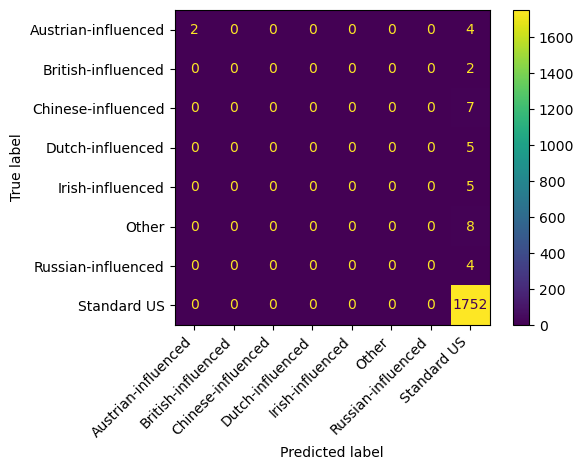

Accuracy of Neural Network: 0.9916


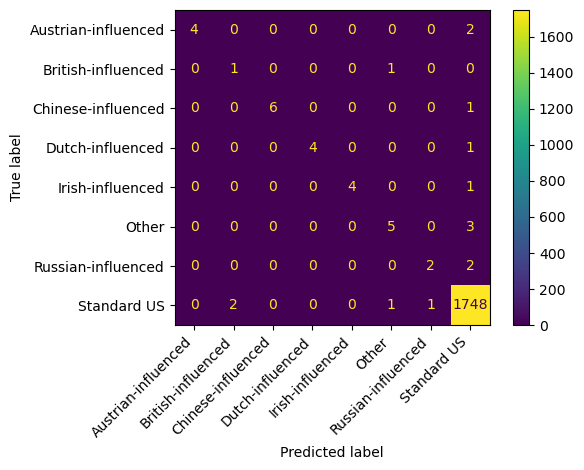

Accuracy of SVM: 0.9793


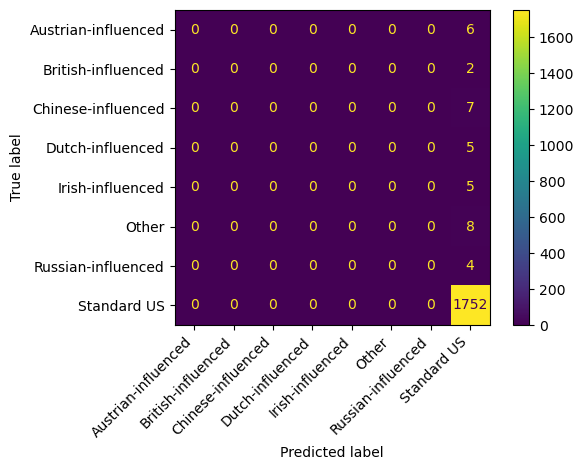

Accuracy of KNN: 0.9961


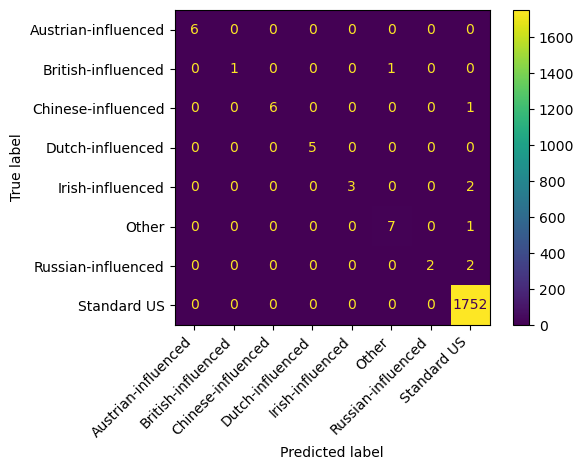

c:\Users\christian fink\anaconda3\envs\voice\Lib\site-packages\sklearn\linear_model\_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Accuracy of Logistic Regression: 0.9793


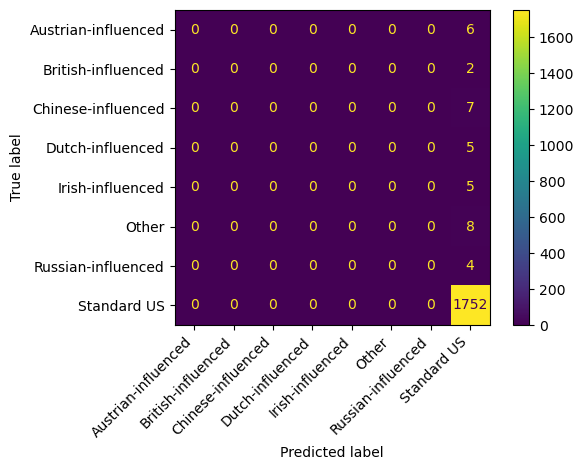

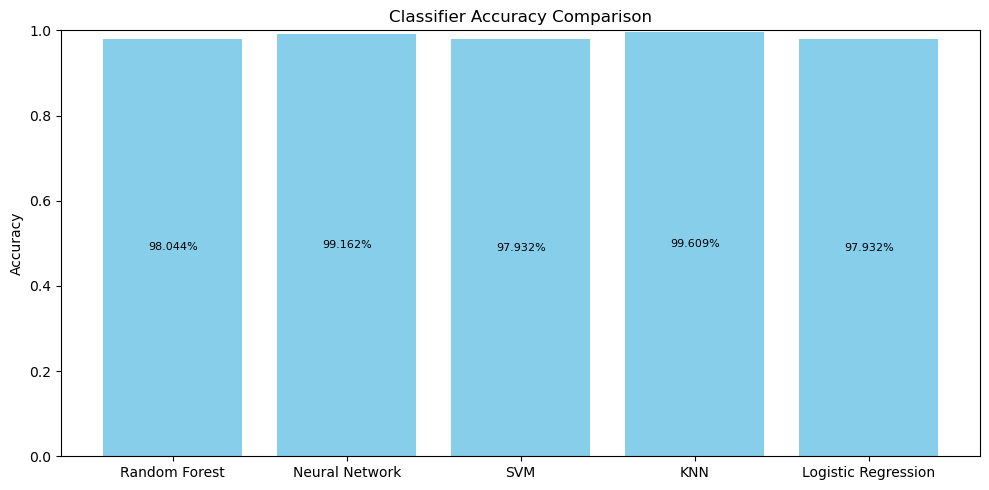

In [ ]:
def view_prediction_results(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    
    print(f'Accuracy of {name}: {accuracy:.4f}')

    ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    return accuracy

def train_and_compare_classifiers(X_train, X_test, y_train, y_test):
    classifiers = {
        'Random Forest': RandomForestClassifier(n_estimators=1000, random_state=8),
        'Neural Network': MLPClassifier(max_iter=1000, random_state=8),
        'SVM': svm.SVC(random_state=8),
        'KNN': KNeighborsClassifier(n_neighbors=5),
        'Logistic Regression': LogisticRegression(multi_class='ovr', max_iter=1000, random_state=8)}
    results = {}
    accuracies = {}
    
    for name, clf in classifiers.items():
        clf.fit(X_train, y_train)
        results[name] = clf
        accuracies[name] = view_prediction_results(name, clf, X_test, y_test)
    
    plt.figure(figsize=(10, 5))
    plt.bar(accuracies.keys(), accuracies.values(), color='skyblue')
    plt.title('Classifier Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)
    for i, acc in enumerate(accuracies.values()):
        plt.text(i, acc / 2, f'{acc * 100:.3f}%', ha='center', va='center', fontsize=8)
    plt.tight_layout()
    plt.show()
    
    return results, accuracies


def prepare_accent_data(voice_feature, feature_names):
    us_accents = voice_feature[voice_feature['accents'].isin(accents_to_keep)]
    us_accents['accent_label'] = us_accents['accents'].apply(lambda x: x.split(',')[1].strip() if ',' in x else x)
    us_accents['accent_label'] = us_accents['accent_label'].apply(simplify_accent_label)
    
    print("\nClass distribution:")
    print(us_accents['accent_label'].value_counts())

    X = us_accents[feature_names]
    y = us_accents['accent_label']
    scaler = preprocessing.MinMaxScaler().fit(X)
    X_scaled = scaler.transform(X)
    
    return X_scaled, y, us_accents['accent_label'].unique()


def main_accent_classification(voice_feature, feature_names):
    X, y, unique_accents = prepare_accent_data(voice_feature, feature_names)
    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=8)
    results, accuracies = train_and_compare_classifiers(X_train, X_test, y_train, y_test)
    
    return results, accuracies

feature_names = col_list_f0 + col_list_mfcc + col_list_zcr
results, accuracies = main_accent_classification(voice_feature, feature_names)
